In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import shapely
import matplotlib.pyplot as plt
import datetime as dt
import pysal
import geoplot

/Users/iv/anaconda3/envs/GIS/lib/python3.6/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


In [2]:
def convertGeometries(df):
    for i in list(df.index):
        geom_type = df.loc[i, 'GeometryType']
        geom = None
        if geom_type == 'Point':
            geom =shapely.geometry.Point(df.loc[i,'Coordinates'])
        elif geom_type == 'GeometryCollection':
            if df.loc[i,'Coordinates'][0] == df.loc[i,'Coordinates'][-1]:
                geom = shapely.geometry.Polygon(df.loc[i,'Coordinates'])
            else:
                geom = shapely.geometry.LineString(df.loc[i,'Coordinates'])
        df.loc[i, 'geometry'] = geom

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/robisoniv/navwarning-analysis/master/CleanedData.csv')
# df = df.sample(frac=0.05)
df = df.drop(columns=['Unnamed: 0'])
df['StartDate'] = pd.to_datetime(df['StartDate'])
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BroadcastingDate'] = pd.to_datetime(df['BroadcastingDate'])
df['Coordinates'] = df['Coordinates'].apply(lambda c: eval(c))
convertGeometries(df)

In [4]:
# df = pd.read_csv('./data-versions/navwarnings-dates-centroids.csv')
# # df = df.sample(frac=0.05)
# df = df.drop(columns=['Unnamed: 0'])
# df['StartDate'] = pd.to_datetime(df['StartDate'])
# df['EndDate'] = pd.to_datetime(df['EndDate'])
# df['BroadcastingDate'] = pd.to_datetime(df['BroadcastingDate'])
# df['Coordinates'] = df['Coordinates'].apply(lambda c: eval(c))
# convertGeometries(df)

In [10]:
gdf = gpd.GeoDataFrame(df)
gdf['centroid'] = gdf['geometry'].centroid
for i in list(gdf.index):
    gdf.loc[i, 'lon_centroid'] = list(gdf.loc[i, 'centroid'].coords[0])[0]
    gdf.loc[i, 'lat_centroid'] = list(gdf.loc[i, 'centroid'].coords[0])[1]

In [7]:
gdf.head()

,Area,Chart,Message,Authority,Date,StartDate,EndDate,BroadcastingDate,GeometryType,geometry,Coordinates,centroid,lon_centroid,lat_centroid
0,CANADA-NORTH COAST. /BEAUFORT SEA.,15940,BOTTOM SCIENTIFIC MOORING EXTENDING 3.5 METERS...,NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-127.688834 70.55800000000001 0),"[(-127.688834, 70.558, 0.0)]",POINT (-127.688834 70.55800000000001),-127.688834,70.558000
1,ARCTIC. /BEAUFORT SEA.,15945,"SCIENTIFIC MOORINGS, TOP FLOAT 29 METERS, ESTA...",NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-133.714 70.0585 0),"[(-133.714, 70.0585, 0.0)]",POINT (-133.714 70.0585),-133.714000,70.058500
2,ARCTIC. /BEAUFORT SEA.,15945,"SCIENTIFIC MOORINGS, TOP FLOAT 29 METERS, ESTA...",NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-133.717167 70.0585 0),"[(-133.717167, 70.0585, 0.0)]",POINT (-133.717167 70.0585),-133.717167,70.058500
3,ARCTIC./CHUCKCHI SEA.,16003,"SCIENTIFIC MOORING, TOP FLOAT 971 FEET, ESTABL...",CGC HEALY,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-158.410434 72.7996 0),"[(-158.410434, 72.7996, 0.0)]",POINT (-158.410434 72.7996),-158.410434,72.799600
4,ARCTIC./CHUKCHI SEA.,16003.,DNC 27. SCIENTIFIC MOORING ESTABLISHED VICINIT...,NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-158.702167 72.615167 0),"[(-158.702167, 72.615167, 0.0)]",POINT (-158.702167 72.615167),-158.702167,72.615167


In [8]:
cols = ['Area', 'Chart', 'Authority', 'Date', 'StartDate',
       'EndDate', 'BroadcastingDate', 'GeometryType',
       'Coordinates', 'lon_centroid', 'lat_centroid']
# gdf[cols].to_csv('gdf-sample.csv')

In [11]:
gdf[cols].to_csv('navwarnings-dates-centroids.csv')

In [154]:
# Let's look at distribution of daily events

df_daily_start = gdf.groupby('StartDate').count()[['Area']].rename(columns={'Area': 'count'})
df_daily_broadcast = gdf.groupby('BroadcastingDate').count()[['Area']].rename(columns={'Area': 'count'})
df_daily_end = gdf.groupby('EndDate').count()[['Area']].rename(columns={'Area': 'count'})

In [233]:
df_daily_broadcast.shape

(76, 1)

In [ ]:
# Look at duration of warning

In [216]:
def plotDailyFigures(df):
    plt.figure(figsize=(10,15))
    plt.subplot(3,1,1)
    plt.scatter(df.index, df['count'])
    plt.subplot(3,1,2)
    plt.hist(df['count'], bins=15)
    plt.subplot(3,1,3)
    plt.plot(df['count'].rolling(7).sum())

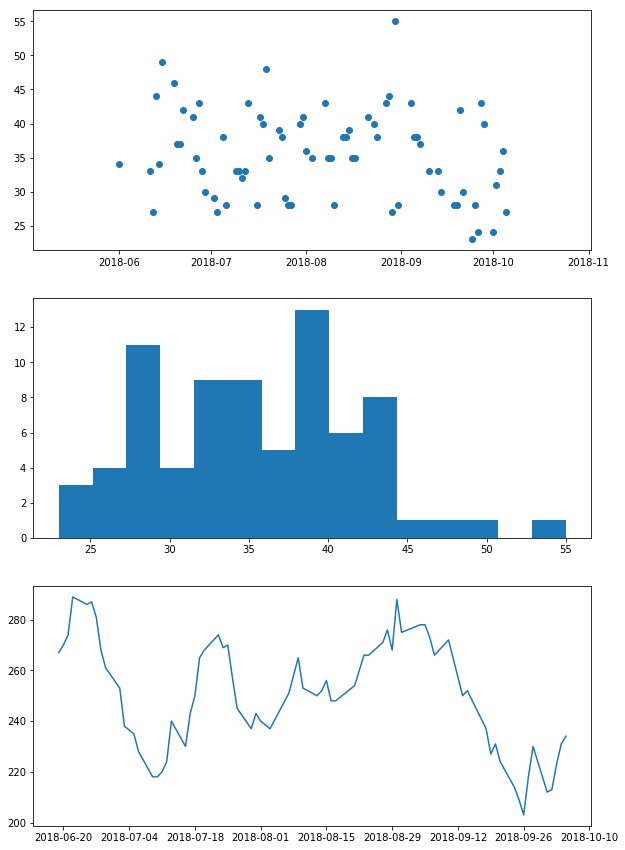

In [217]:
plotDailyFigures(df_daily_broadcast)

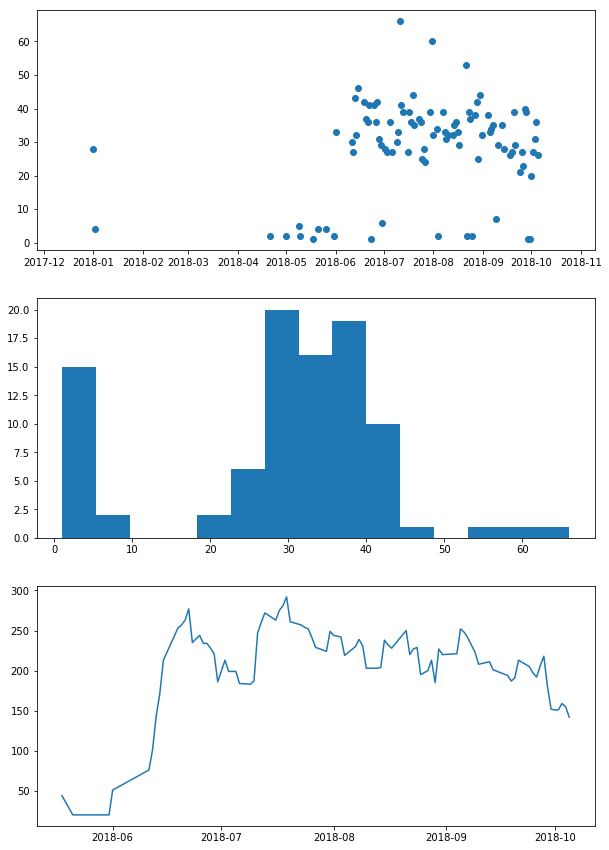

In [218]:
plotDailyFigures(df_daily_start)

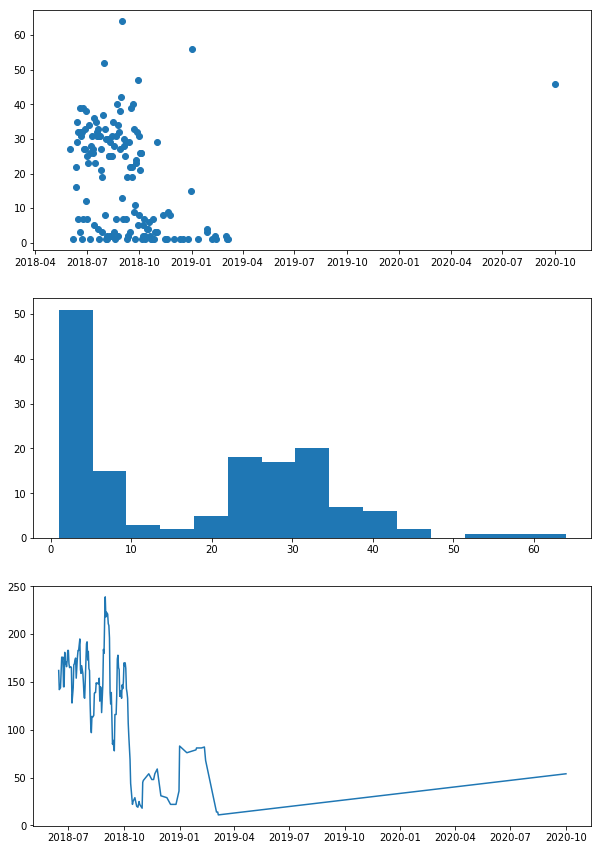

In [219]:
plotDailyFigures(df_daily_end)

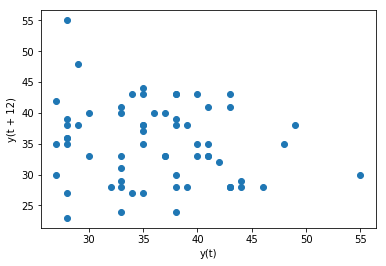

In [160]:
pd.plotting.lag_plot(df_daily_broadcast, lag=12)

In [229]:
def calculateAutocorrelation(lags=50):
    df_tmp = pd.DataFrame(columns=['start', 'broadcasting', 'end']) 
    for lag in range(lags):
        df_tmp.loc[lag,'broadcasting'] = df_daily_broadcast['count'].autocorr(lag=lag)
#         df_tmp.loc[lag,'start'] = df_daily_start['count'].autocorr(lag=lag)
#         df_tmp.loc[lag,'end'] = df_daily_end['count'].autocorr(lag=lag)

    return df_tmp

In [234]:
df_autocorrelation = calculateAutocorrelation(76)

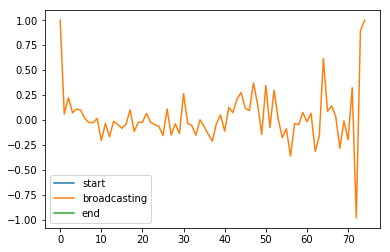

In [235]:
df_autocorrelation.plot()

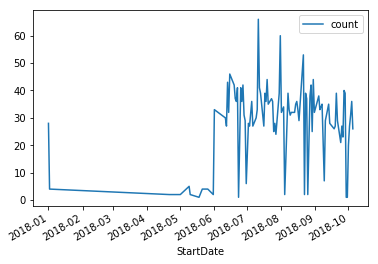

In [164]:
df_daily_start.plot()

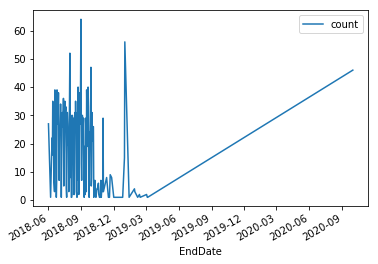

In [165]:
df_daily_end.plot()

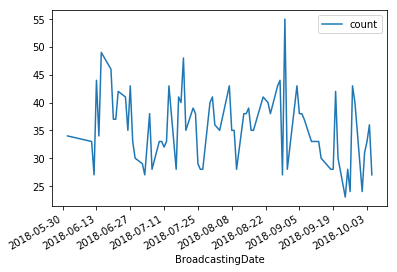

In [166]:
df_daily_broadcast.plot()

In [167]:
# Do we do an ACF or PACF analysis here? Can't quite tell ....
# Or ARIMA?

In [168]:
# Getis G
points = gdf['centroid'].values

In [169]:
go = True
centroids = []
for i in gdf.iterrows():
    lat = i[1].lat_centroid
    lon = i[1].lon_centroid
    centroids.append((lon, lat))


In [190]:
# The weights matrix with a threshold of 1.0 (unit - i.e. decimal degree)
# This parameter needs investigation. Also, we should be using Haversine rather than Euclidean
# distance unless we reproject the coordinates into azimuthal equidistant, I think

w = pysal.weights.DistanceBand(centroids, threshold=10.0)
w.transform = 'B'

/Users/iv/anaconda3/envs/TEST/lib/python2.7/site-packages/pysal/weights/weights.py:189: UserWarning: There are 44 disconnected observations
  warnings.warn("There are %d disconnected observations" % ni)
/Users/iv/anaconda3/envs/TEST/lib/python2.7/site-packages/pysal/weights/weights.py:190: UserWarning: Island ids: 57, 120, 198, 206, 385, 397, 406, 411, 518, 610, 698, 1025, 1095, 1101, 1155, 1184, 1204, 1254, 1291, 1330, 1402, 1466, 1555, 1607, 1662, 1757, 1857, 1873, 1926, 1974, 2030, 2048, 2082, 2115, 2210, 2221, 2258, 2264, 2360, 2424, 2467, 2473, 2485, 2556
  warnings.warn("Island ids: %s" % ', '.join(str(island) for island in self.islands))


In [191]:
y = np.ones(len(centroids))

In [195]:
g = pysal.esda.getisord.G(y, w)
moransi = pysal.esda.moran.Moran(y,w)

print("Getis Ord G :", g.G)
print("Getis Ord p :", g.p_norm)
print("Moran's I   :", moransi.I)
print("Moran's I p :", moransi.p_norm)

# Resources:
# https://pysal.readthedocs.io/en/dev/_modules/pysal/esda/getisord.html#G
# https://esda.readthedocs.io/en/latest/generated/esda.Moran.html#esda.Moran
#

('Getis Ord G :', 0.04693763737705981)
('Getis Ord p :', 0.5)
("Moran's I   :", nan)
("Moran's I p :", nan)


In [12]:
gdf

,Area,Chart,Message,Authority,Date,StartDate,EndDate,BroadcastingDate,GeometryType,geometry,Coordinates,centroid,lon_centroid,lat_centroid
0,CANADA-NORTH COAST. /BEAUFORT SEA.,15940,BOTTOM SCIENTIFIC MOORING EXTENDING 3.5 METERS...,NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-127.688834 70.55800000000001 0),"[(-127.688834, 70.558, 0.0)]",POINT (-127.688834 70.55800000000001),-127.688834,70.558000
1,ARCTIC. /BEAUFORT SEA.,15945,"SCIENTIFIC MOORINGS, TOP FLOAT 29 METERS, ESTA...",NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-133.714 70.0585 0),"[(-133.714, 70.0585, 0.0)]",POINT (-133.714 70.0585),-133.714000,70.058500
2,ARCTIC. /BEAUFORT SEA.,15945,"SCIENTIFIC MOORINGS, TOP FLOAT 29 METERS, ESTA...",NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-133.717167 70.0585 0),"[(-133.717167, 70.0585, 0.0)]",POINT (-133.717167 70.0585),-133.717167,70.058500
3,ARCTIC./CHUCKCHI SEA.,16003,"SCIENTIFIC MOORING, TOP FLOAT 971 FEET, ESTABL...",CGC HEALY,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-158.410434 72.7996 0),"[(-158.410434, 72.7996, 0.0)]",POINT (-158.410434 72.7996),-158.410434,72.799600
4,ARCTIC./CHUKCHI SEA.,16003.,DNC 27. SCIENTIFIC MOORING ESTABLISHED VICINIT...,NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-158.702167 72.615167 0),"[(-158.702167, 72.615167, 0.0)]",POINT (-158.702167 72.615167),-158.702167,72.615167
5,ARCTIC./CHUKCHI SEA.,16003.,DNC 27. SCIENTIFIC MOORING ESTABLISHED VICINIT...,NAVAREA XVII,No date listed,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-158.412667 72.800167 0),"[(-158.412667, 72.800167, 0.0)]",POINT (-158.412667 72.800167),-158.412667,72.800167
6,ARCTIC./BEAUFORT SEA./DNC 27.,15926.,"SCIENTIFIC MOORING, AT DEPTH 61 METERS, ESTABL...",NAVAREA XVII,2015-10-01 00:00:00,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-139.020667 70.432334 0),"[(-139.020667, 70.432334, 0.0)]",POINT (-139.020667 70.432334),-139.020667,70.432334
7,ARCTIC./BEAUFORT SEA./DNC 27.,15926.,"SCIENTIFIC MOORINGS, AT DEPTH 183 METERS AND A...",NAVAREA XVII,2015-10-02 00:00:00,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-135.011 70.86966700000001 0),"[(-135.011, 70.869667, 0.0)]",POINT (-135.011 70.86966700000001),-135.011000,70.869667
8,ARCTIC./BEAUFORT SEA./DNC 27.,15926.,"SCIENTIFIC MOORINGS, AT DEPTH 183 METERS AND A...",NAVAREA XVII,2015-10-02 00:00:00,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-135.019167 70.869 0),"[(-135.019167, 70.869, 0.0)]",POINT (-135.019167 70.869),-135.019167,70.869000
9,ARCTIC./CHUKCHI SEA./DNC 27.,16005.,SUB-SURFACE SCIENTIFIC MOORINGS ESTABLISHED IN...,USCGC HEALY,2016-08-04 00:00:00,2018-06-01,2018-06-01,2018-06-01,Point,POINT Z (-161.500184 71.600117 0),"[(-161.500184, 71.600117, 0.0)]",POINT (-161.500184 71.600117),-161.500184,71.600117
